# Прогнозирование температуры звезды

**Описание исследования**

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.
Обсерватория «Небо на ладони» хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.
Каждый из них имеет плюсы и минусы, наша задача попытаться разработать более точный и быстрый метод при помощи нейросетей.

**Цель исследования:**

Подобрать лучшую нейросеть для определение температуры на поверхностии звезд по имеющимся данным. При оценке основными критериями считать: 

- качество предсказания (RMSE<4500 кельвинов);

**Описание исходных данных**

Данные находятся в файле */datasets/6_class.csv* 

Признаки:
 - Относительная светимость L/Lo — светимость звезды относительно Солнца.
 - Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
 - Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
 - Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
 - Тип звезды.
 
Целевой признак:
 - Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Импорты и настройки

In [1]:
!pip install -U scikit-learn -q
!pip install sweetviz -q
!pip install phik -q
!pip install optuna -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time

import optuna
import torch

from optuna.trial import TrialState
from phik.report import plot_correlation_matrix
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import sweetviz as sv
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [3]:
# обьявляем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# настраиваем отображение таблиц
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Загрузка данных

In [5]:
try:
    df_stars = pd.read_csv('/datasets/6_class.csv')
    df_stars.name = 'df_stars'
except:
    df_stars = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv')
    df_stars.name = 'df_stars'

In [6]:
# провряем что все загрузилось
df_stars.head(5)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


## Предобработка и анализ данных

                                             |          | [  0%]   00:00 -> (? left)


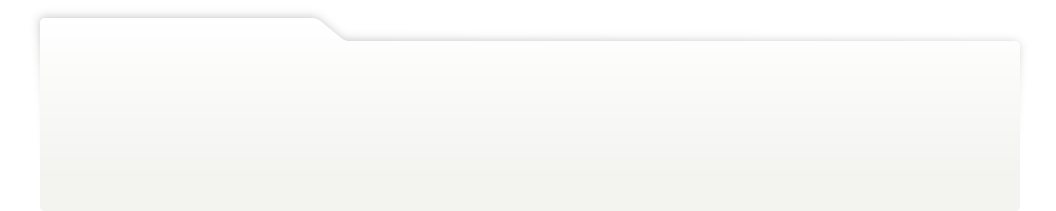
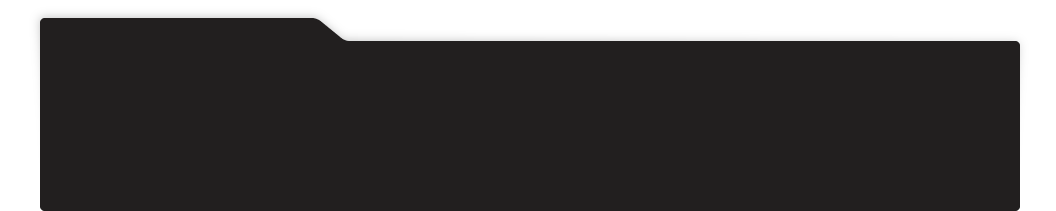
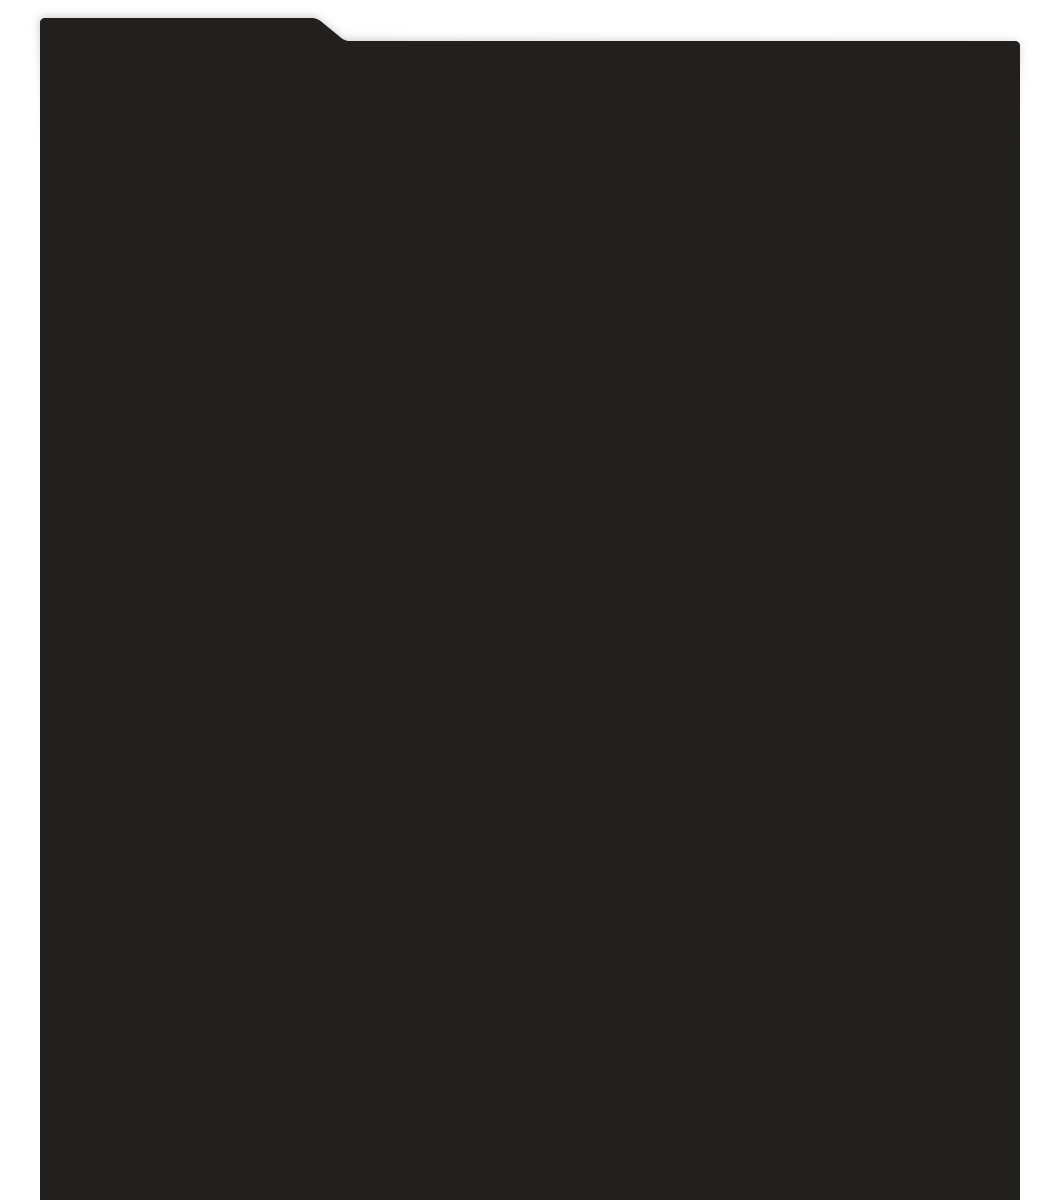
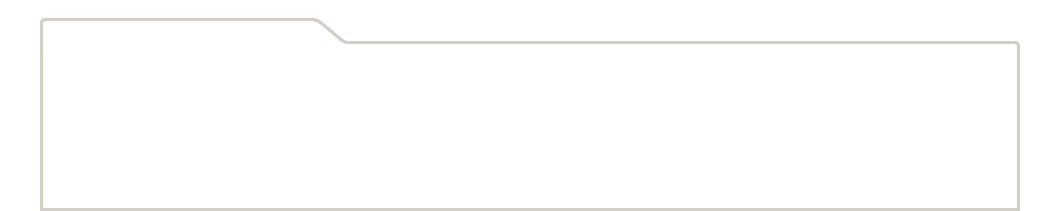
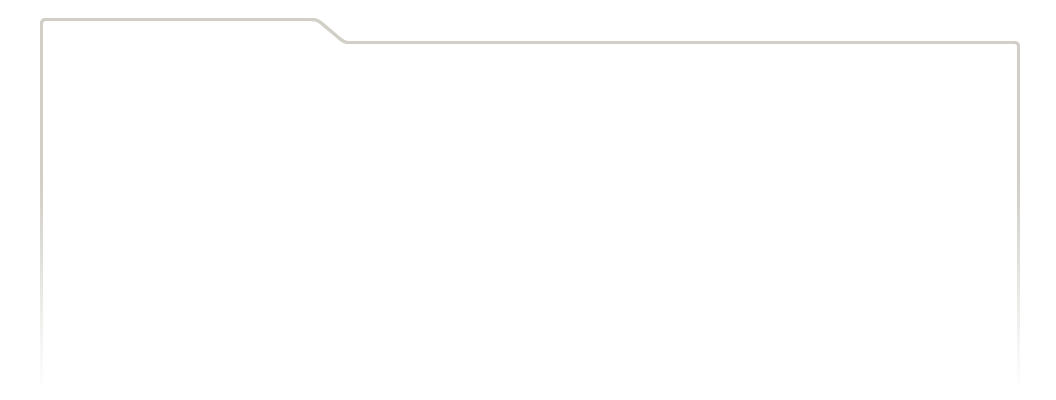
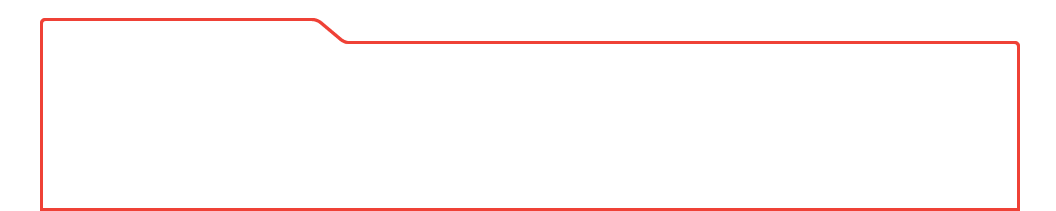
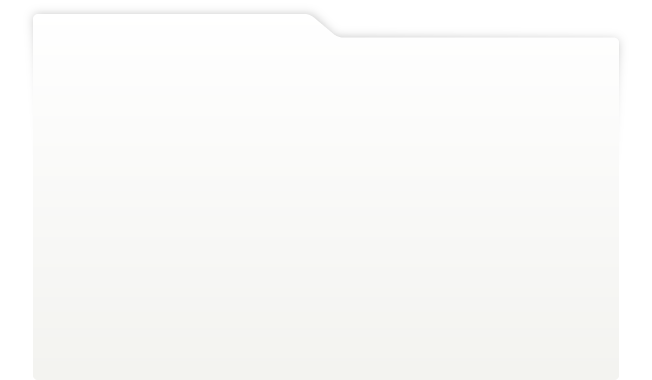
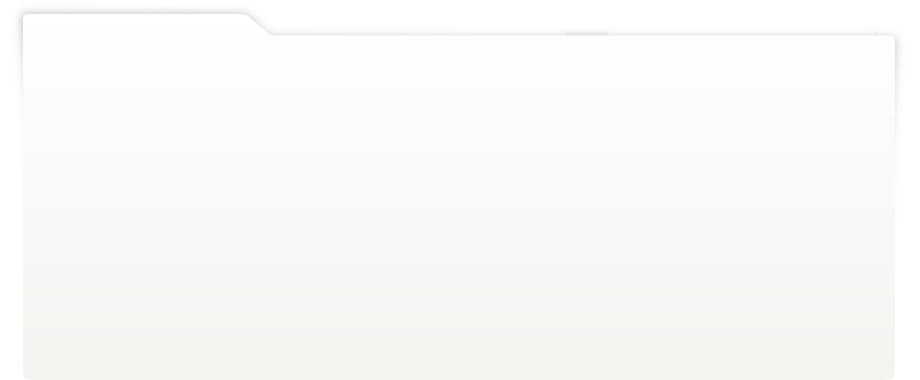
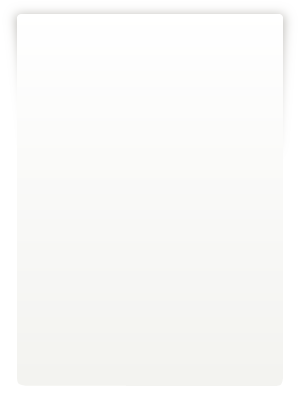
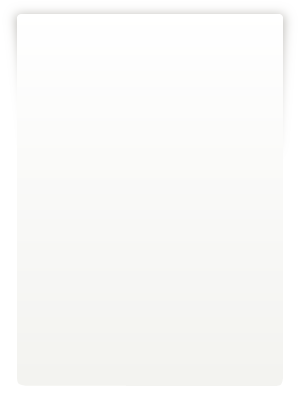
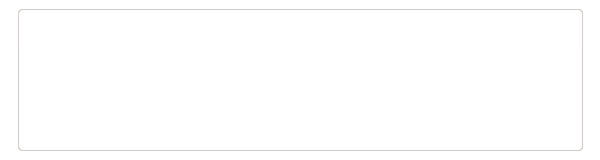
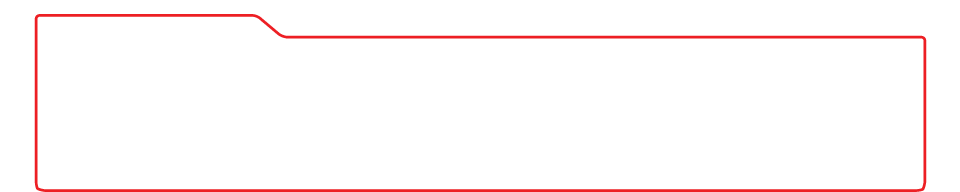
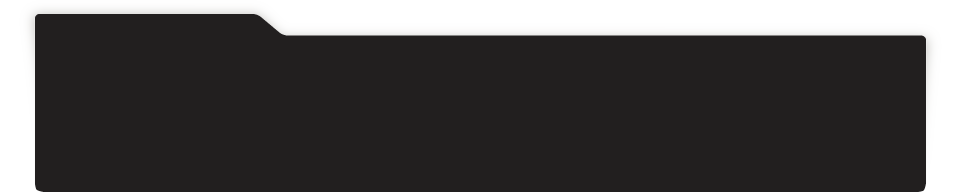
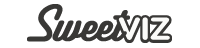
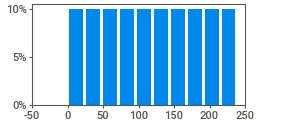
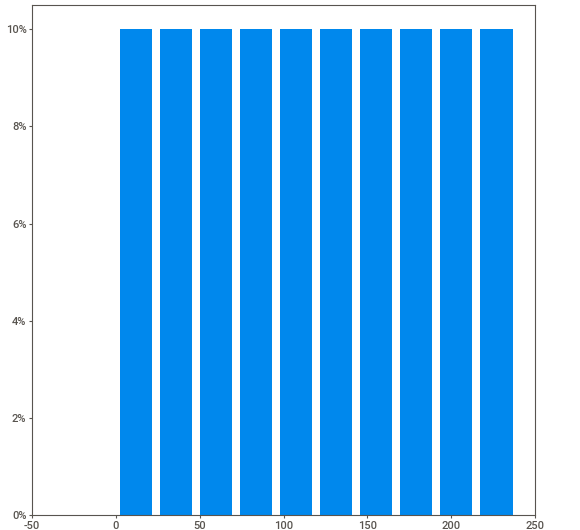
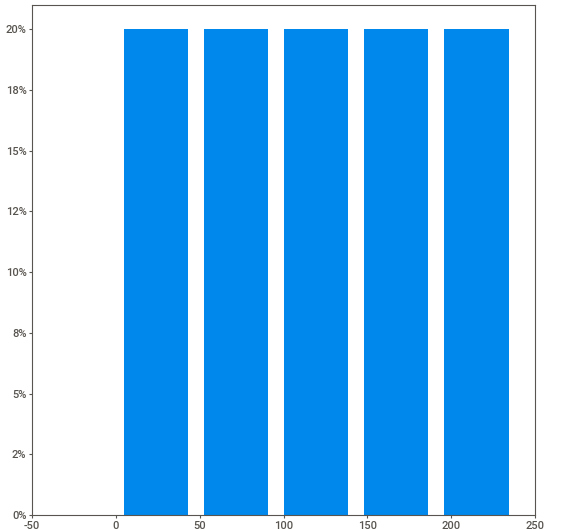
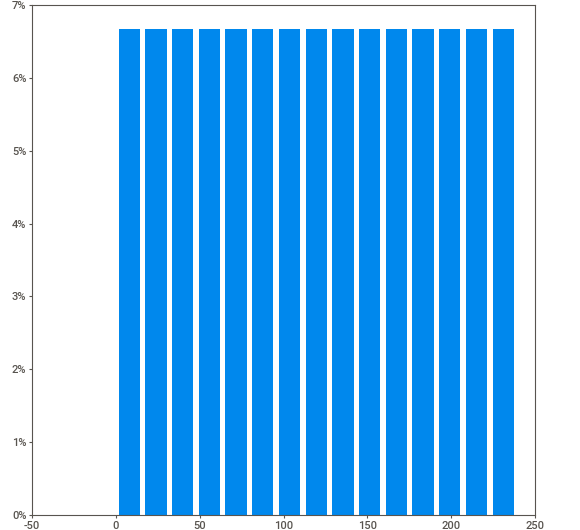
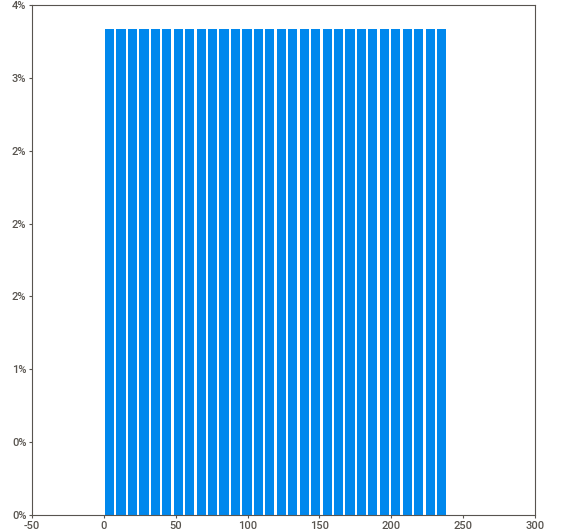
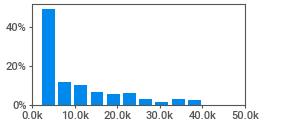
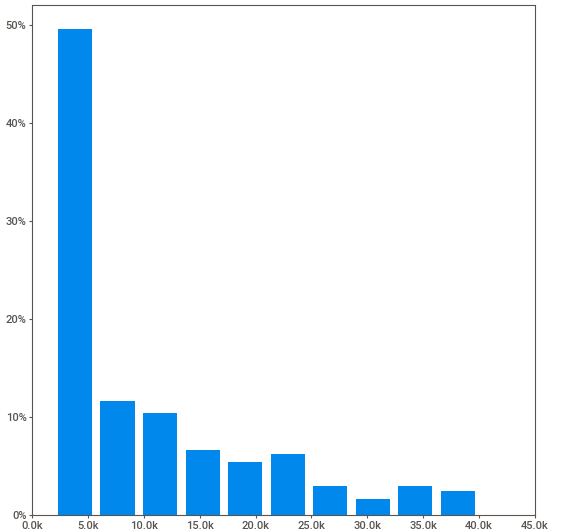
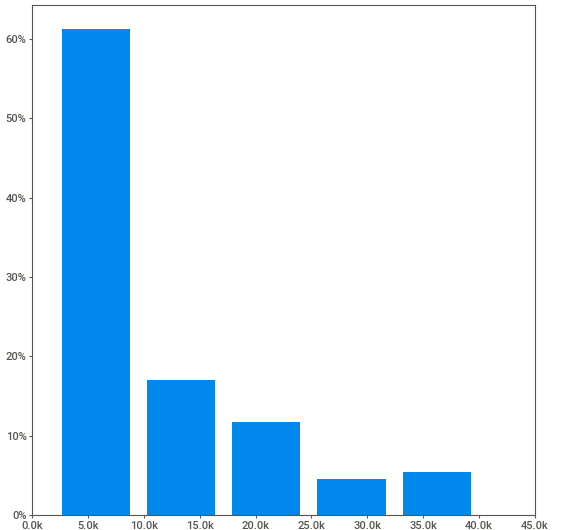
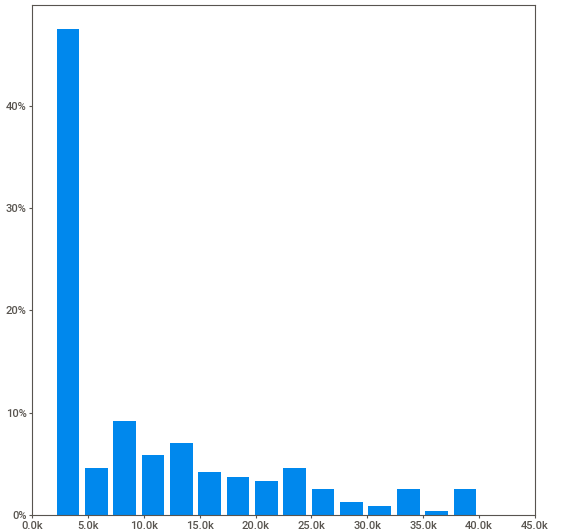
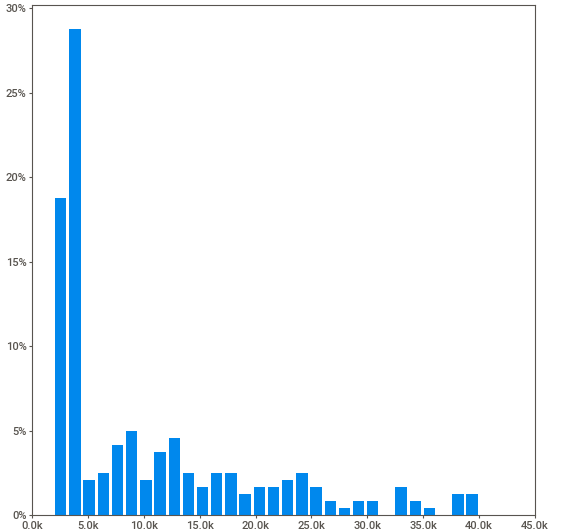
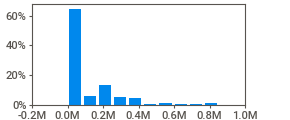
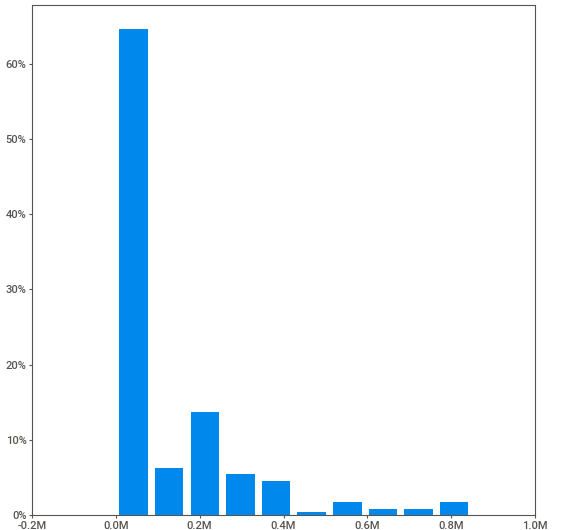
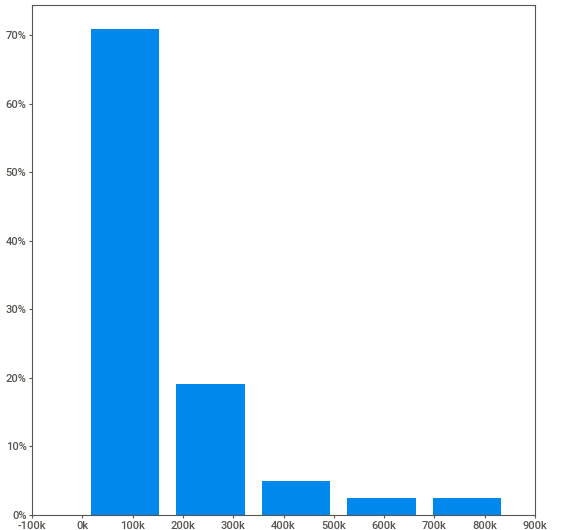
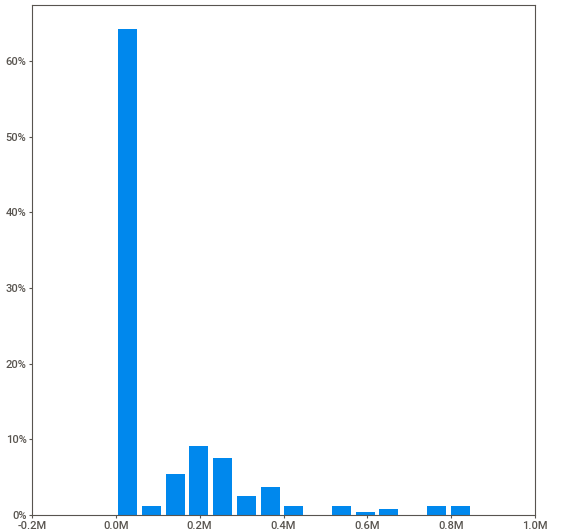
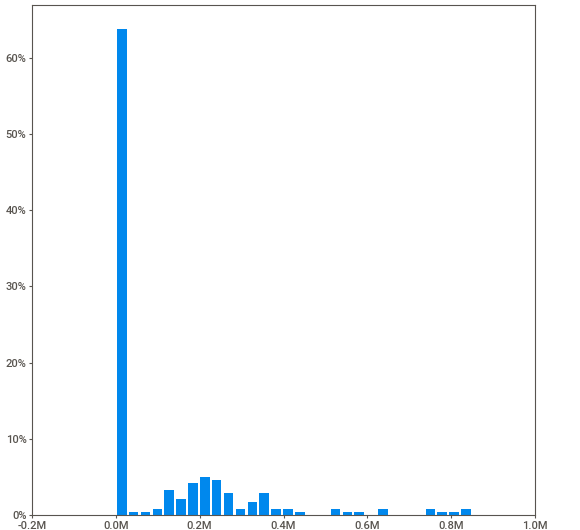
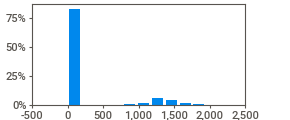
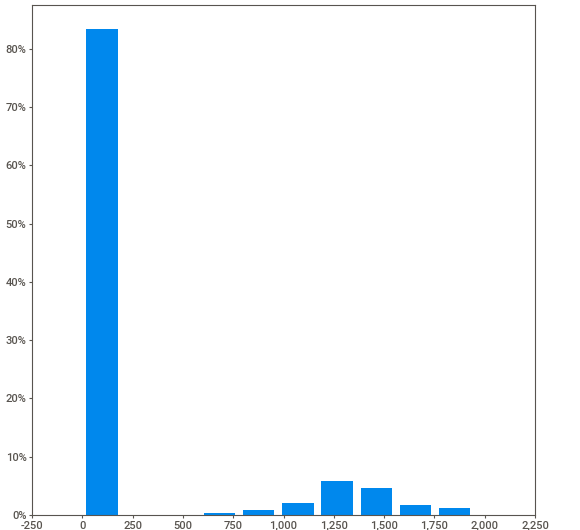
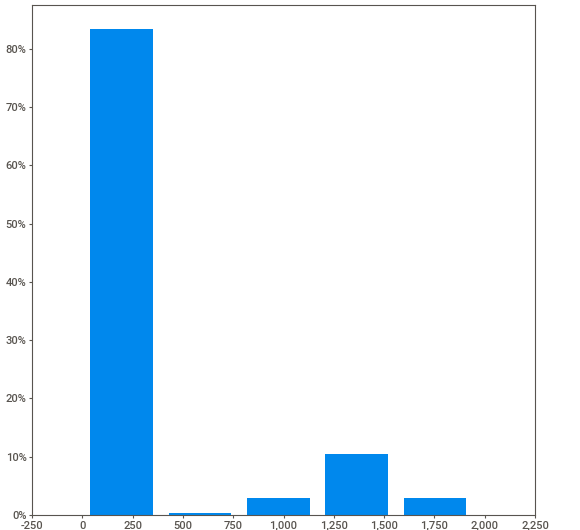
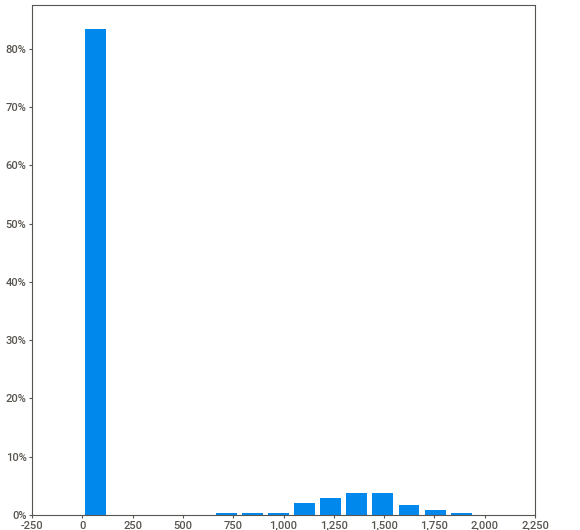
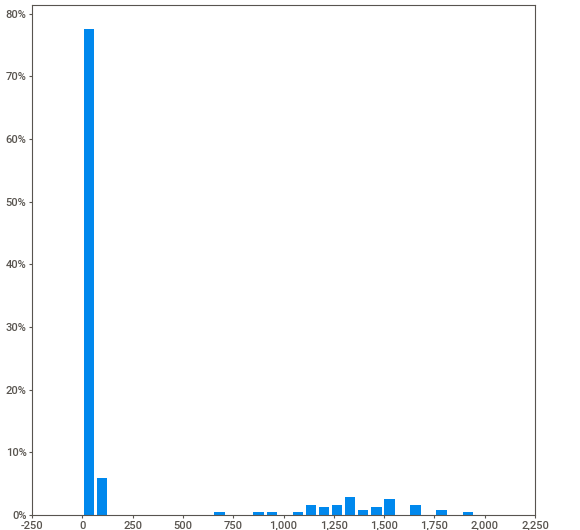
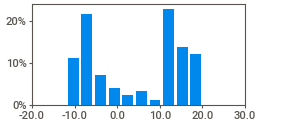
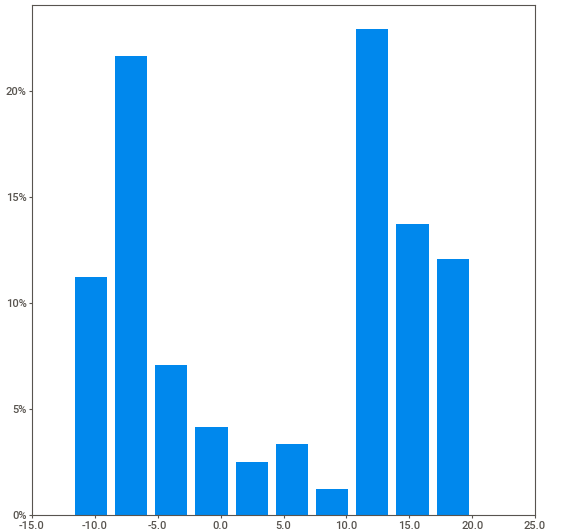
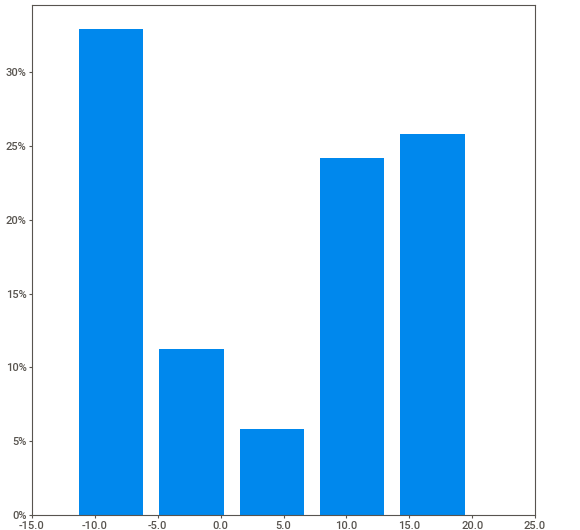
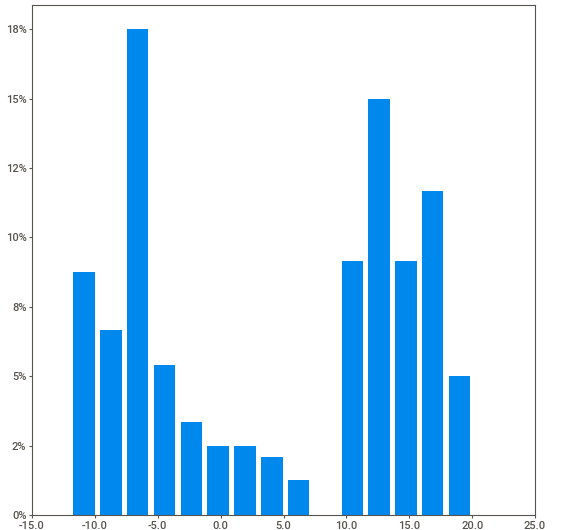
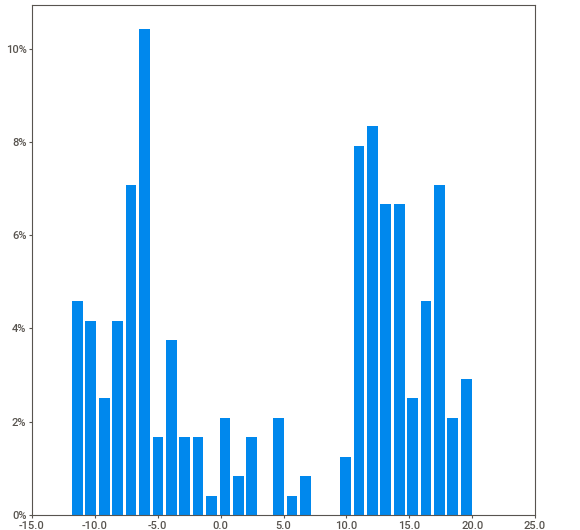
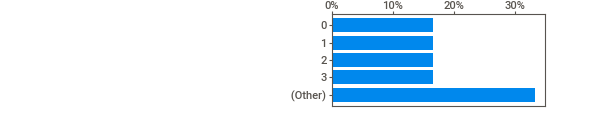
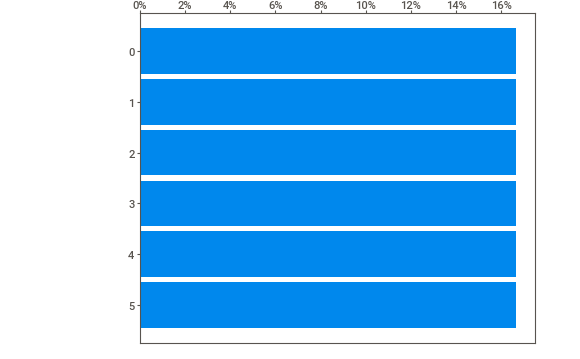
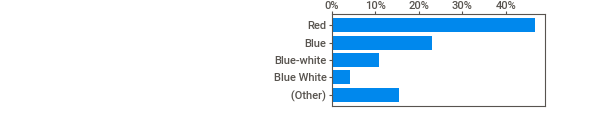
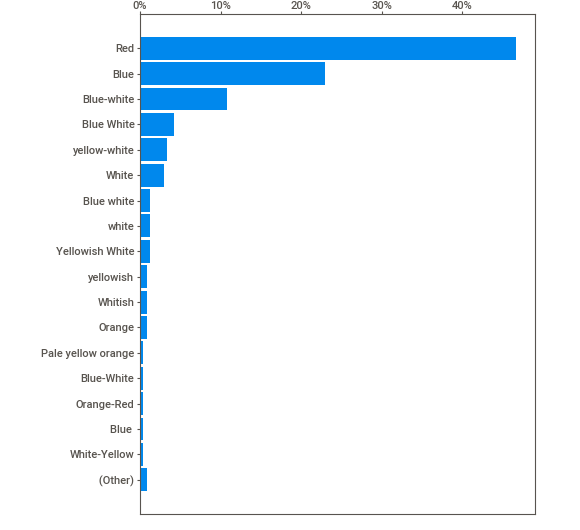
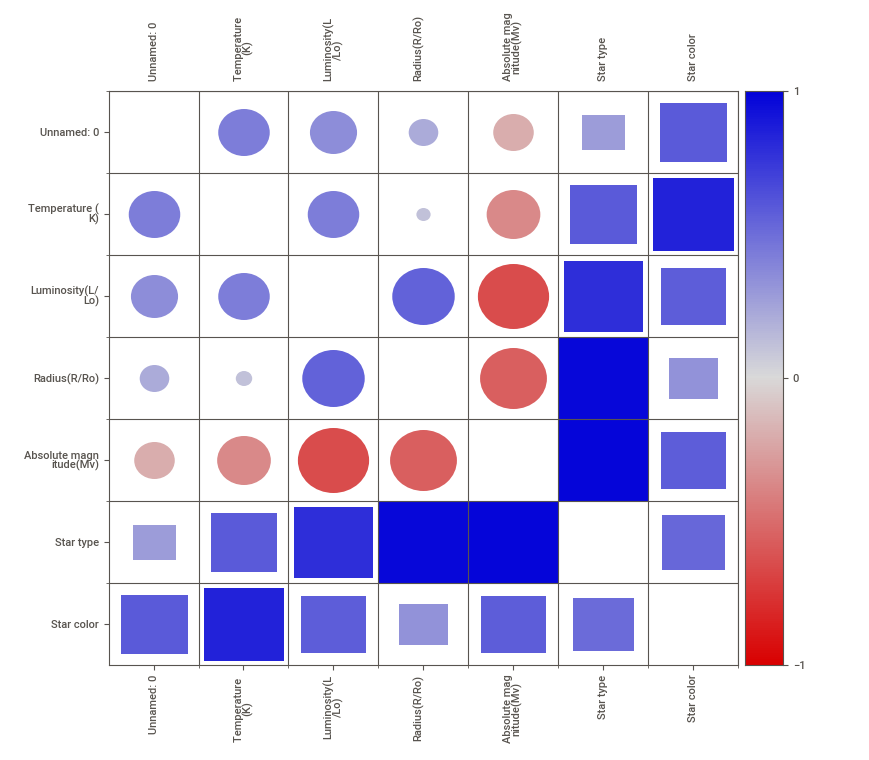
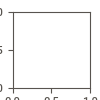

In [7]:
#осмотр и предварительный анализ данных при помощи sweetviz
report = sv.analyze([df_stars, "Данные о звездах"])
report.show_notebook()

**Выводы по осмотру данных:**
- имеем 7 признаков, включая целевой;
- признак 'Unnamed: 0' не несет ценности, так как дублирует индекс, его в последствии удалим.
- категориальные признаки:
    - Star type: пропусков нет, имеем равное количество наблюдений для каждого из 6 типов;
    - Star color: пропусков нет, имеем 19 значений (от 112 до 1 наблюдения для категории), но наблюдаем неявные дубликаты, в дальнейшем их стоит обработать.
- количественные признаки:
    - Luminosity(L/Lo): пропусков нет, распределение скошенное, большая часть наблюдений сосредоточена около 0, диапазон наблюдений от 0 до 849 420 ед., в целом все эти значения вполне возможны, поэтому не будем ничего удалять.
    - Radius(R/Ro): пропусков нет, большая часть наблюдений сосредоточена около 0, распределение не нормальное, диапазон наблюдений от 0 до 1948.5 ед.ю, значения такие значения в данной области тоже возможны, поэтому смысла уменьшать датасет нет.
    - Absolute magnitude(Mv): пропусков нет, распределение похоже на бимодальное, самые частые значения наблюдаем в диапазона 14-12 и -7-(-10).
- целевой признак:
    - Temperature (K): пропусков нет, распредеение скошенное, наиболее часто встречаются значения в районе 3600К, диапазон значений от 1939 до 40000K.

In [8]:
df_stars['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

В данной колонке присутстауют неявные дубликаты. Ознакомившись со статьей (https://en.wikipedia.org/wiki/Stellar_classification) о классификации звезд по цвету излучения избавимся от них.

In [9]:
df_stars['Star color'] = df_stars['Star color'].replace(
                                 ['Blue white', 'Blue-white', 'Blue white ', 'Blue-White'], 'Blue White')
df_stars['Star color'] = df_stars['Star color'].replace(
        ['yellow-white', 'White-Yellow', 'yellowish', 'Yellowish', 'White Yellow','Yellow-White'], 'Yellowish White')
df_stars['Star color'] = df_stars['Star color'].replace(['Blue '],'Blue')
df_stars['Star color'] = df_stars['Star color'].replace(['Orange-Red'],'Red')
df_stars['Star color'] = df_stars['Star color'].replace(['Pale yellow orange'],'Orange')
df_stars['Star color'] = df_stars['Star color'].replace(['white', 'Whitish'],'White')

In [10]:
df_stars['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Orange', 'Blue'],
      dtype=object)

In [11]:
df_stars['Star color'].value_counts()

Red                113
Blue                56
Blue White          41
Yellowish White     15
White               12
Orange               3
Name: Star color, dtype: int64

In [12]:
df_stars.duplicated().sum()

0

In [13]:
# от данного столбца пользы мы не получим, он дублирует индексы
df_stars.drop(columns = ['Unnamed: 0'], inplace=True)

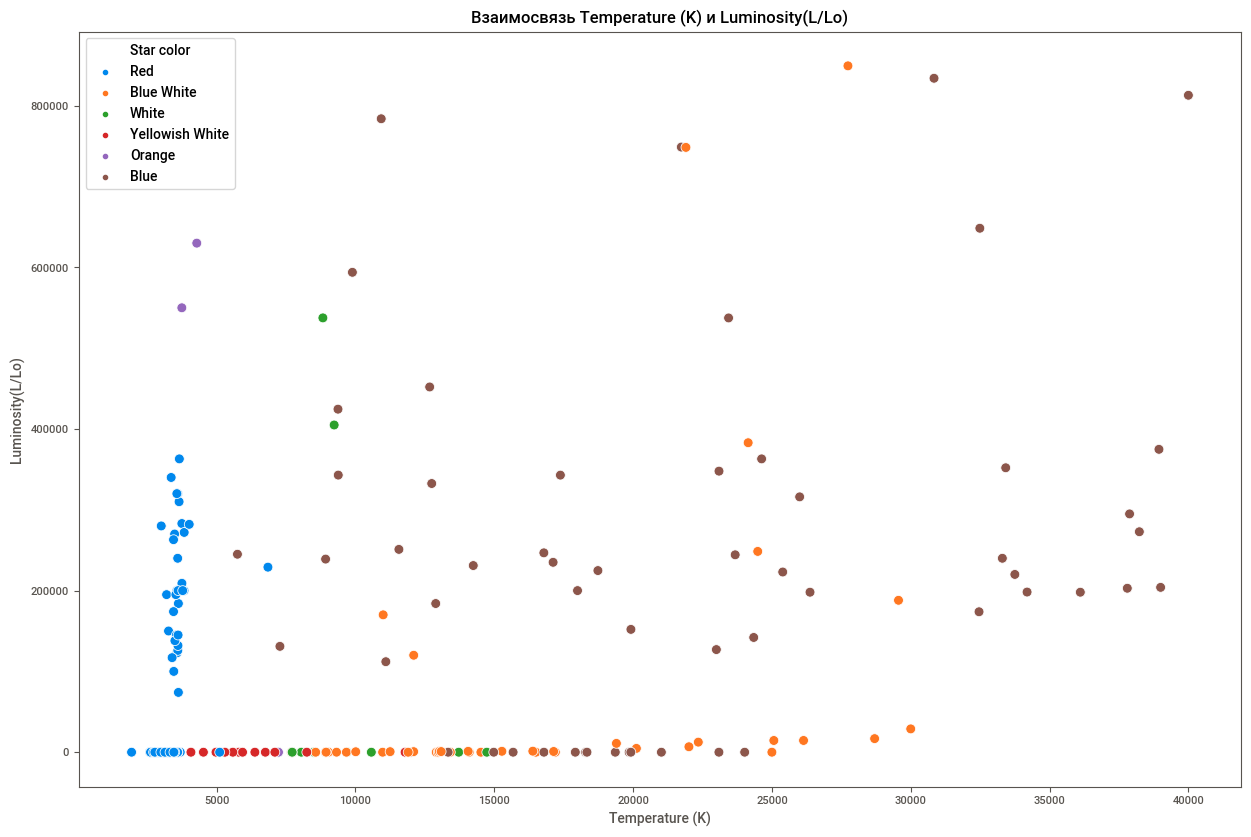

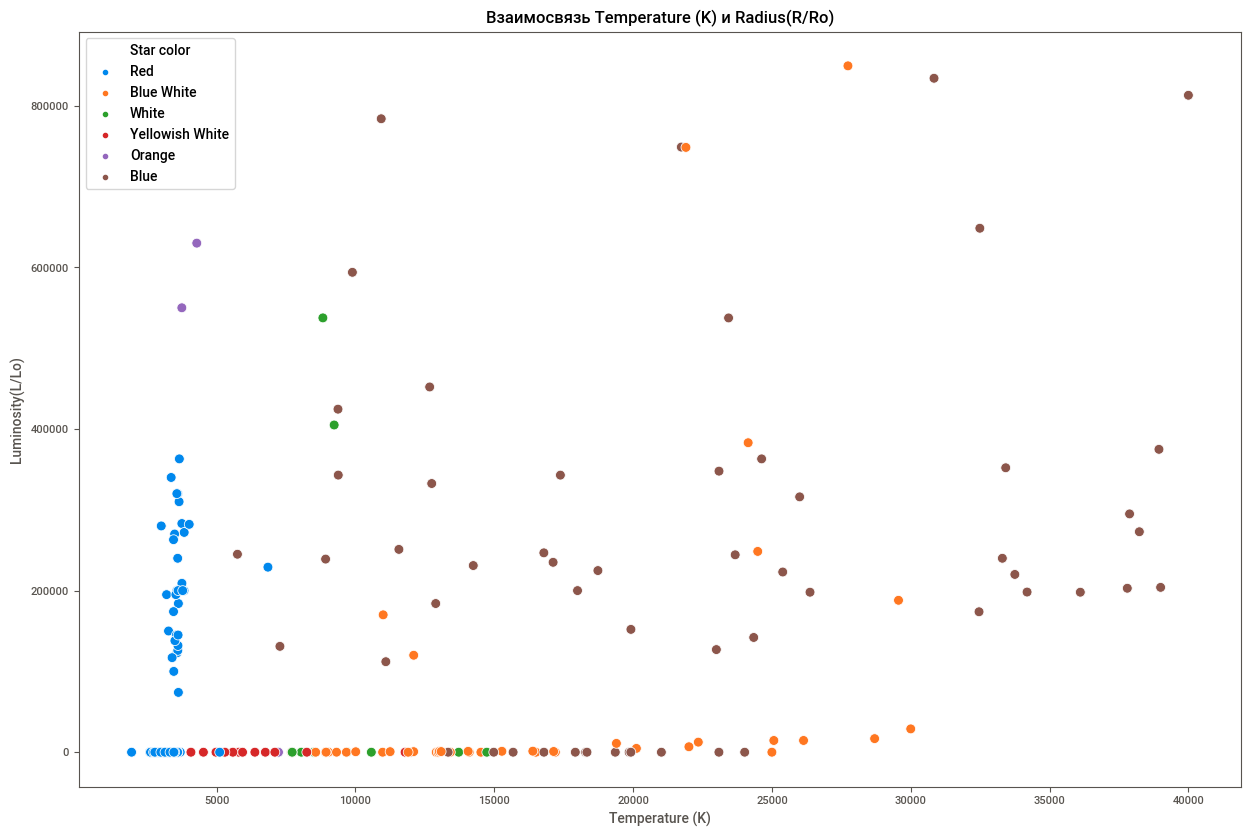

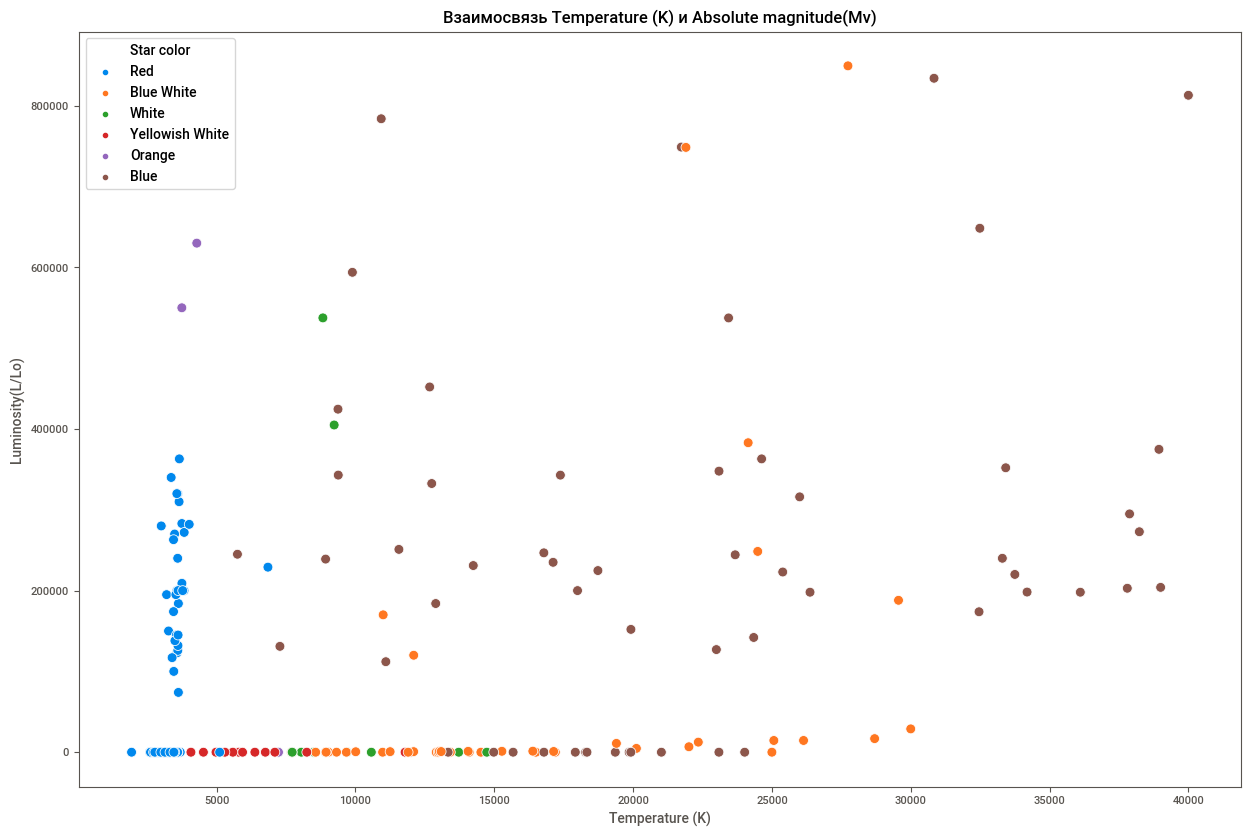

In [14]:
list_col = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)',  ]
for x_c in list_col:
    plt.figure(figsize = (15,10), dpi = 100)
    plt.title(f'Взаимосвязь Temperature (K) и {x_c}')
    sns.scatterplot(x = 'Temperature (K)', y = 'Luminosity(L/Lo)', hue='Star color',
                data =df_stars,s =50);

На графиках явной линейной зависимости между количественными признаками и целевой переменной не наблюдается, возможно это стоило бы улучшить путем возведения некоторых признаком в степень или приведением к логарифмам, но эти попытки не принесли существенного улучшения метрик в модели, поэтому включать их в работу я не стал.

Посмотри на корреляцию признаков.

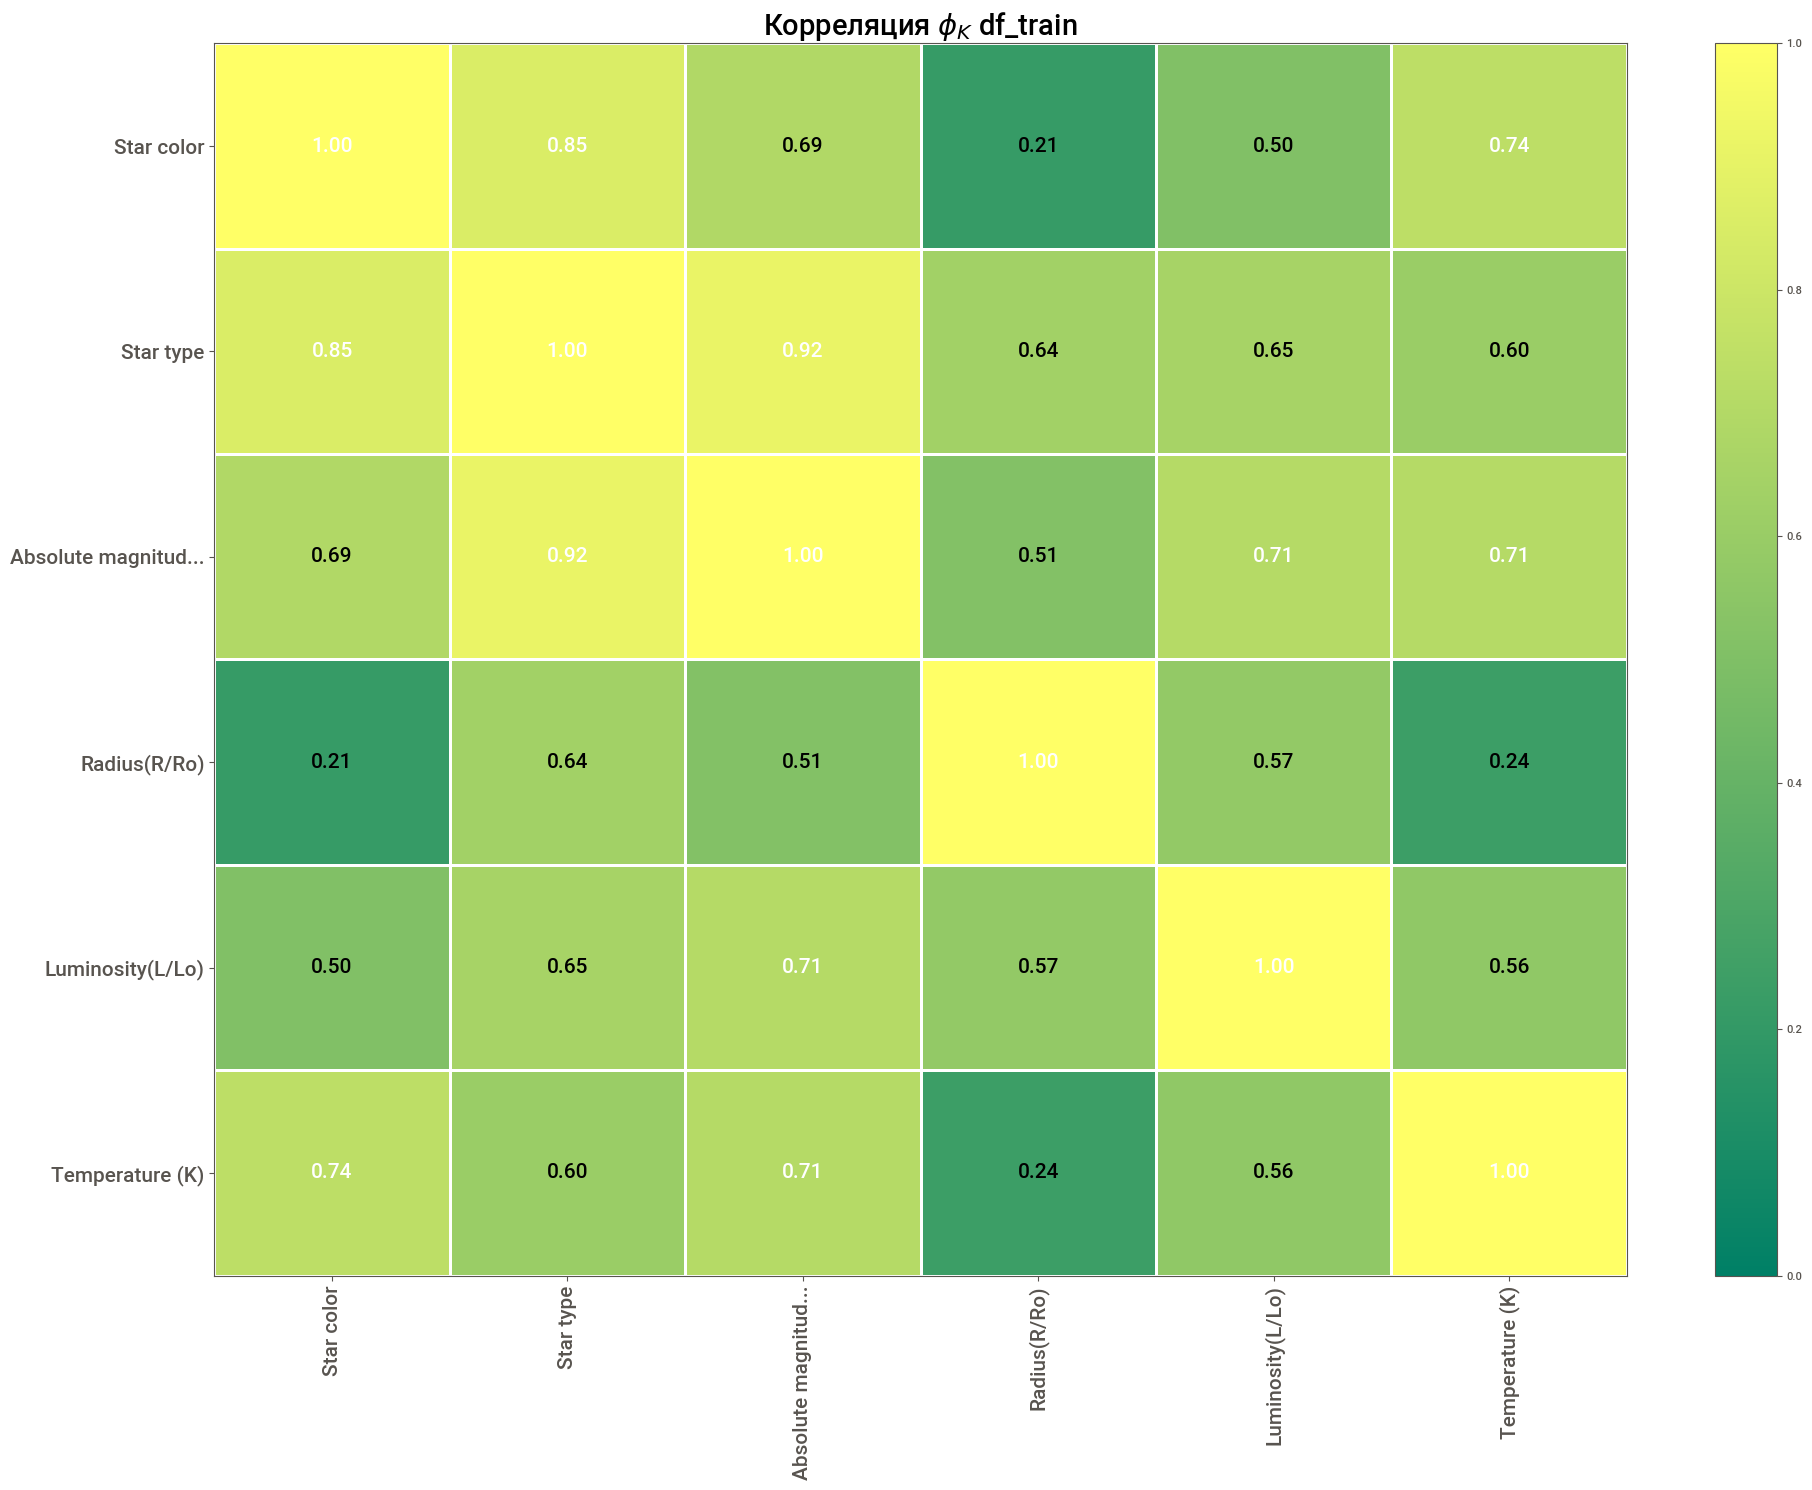

In [15]:
phik_overview = (
    df_stars
    .phik_matrix(verbose=False, interval_cols=['Temperature (K)',
                                               'Luminosity(L/Lo)',
                                               'Radius(R/Ro)',
                                               'Absolute magnitude(Mv)',
                                              ]))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='summer',
    title=r'Корреляция $\phi_K$ df_train',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Выводы по предобработке и анализу данных:**

 - данные типизированы корректно, дубликатов не обнаружено, пропуско вне обнаружено;
 - обработаны неявные дубликаты в столбце Star color;
 - удален дублирующий индекс признак;
 - явных линейных зависимостей между количественными признаками и целевы обнаружить не удалось;
 - присутствет мультиколлинеарность между признаками Absolute magnitude(Mv) и Star type, но исключение какого либо из эти признаков положительно на модели не скажется, поэтому оставим оба.

## Подготовка к построению модели

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_stars.drop('Temperature (K)', axis = 1),
                                                    df_stars['Temperature (K)'],
                                                    test_size=TEST_SIZE,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

#проверка размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(180, 5) (60, 5) (180,) (60,)


In [17]:
num_col = ['Luminosity(L/Lo)','Radius(R/Ro)','Absolute magnitude(Mv)']
cat_col = ['Star color', 'Star type']

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), num_col),
                            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False), cat_col)],
                                remainder="passthrough"
                                  )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

**Промежуточные выводы:**
- данные корректно разделены на тренировочную и тестовую выборки,
- количественные данные стандартизированы, категориальные обработаны при помощи OneHotEncoder

## Построение базовой нейронной сети

Как базовую рассмотри модель с 2мя скрытыми слоями с разделением на 40 батчей.

In [18]:
# подготовка тензоров
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

In [19]:
class Net_one(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net_one, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [20]:
# зафиксируем количество нейронов как требуется в задании.
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 12
n_out_neurons = 1

In [21]:
net = Net_one(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)


In [22]:
def fact_pred_chart(predict_T, y_test):
    """Функция для построение графика факт-прогноз."""
    
    y1 = torch.FloatTensor(predict_T)
    y1 = y1.detach().numpy().reshape([-1])
    y2 = y_test.detach().numpy().reshape([-1])
    x = np.arange(len(y1))

    fig,axes = plt.subplots(dpi=100)
    fig.set_figwidth(20)
    fig.set_figheight(8)
    axes.set_xticks(x)
    axes.bar(x, y2, width = 0.7, label = 'Факт', color='darkgreen')
    axes.bar(x, y1, width = 0.3, label = 'Прогноз', color='yellow')
    axes.legend()
    axes.set_title("Факт-Прогноз", fontsize=20)
    axes.set_xlabel('Номер звезды в таблице данных')
    axes.set_ylabel('Температура звезды')
    plt.show()

Эпоха:0, RMSE на трейне: 11731.0966796875
Эпоха:0, RMSE на тесте: 14626.9140625

Эпоха:100, RMSE на трейне: 11513.9306640625
Эпоха:100, RMSE на тесте: 14355.75

Эпоха:200, RMSE на трейне: 10288.33984375
Эпоха:200, RMSE на тесте: 12799.9609375

Эпоха:300, RMSE на трейне: 8528.037109375
Эпоха:300, RMSE на тесте: 10413.90625

Эпоха:400, RMSE на трейне: 7467.443359375
Эпоха:400, RMSE на тесте: 8761.869140625

Эпоха:500, RMSE на трейне: 6884.328125
Эпоха:500, RMSE на тесте: 7989.13818359375

Эпоха:600, RMSE на трейне: 6478.6943359375
Эпоха:600, RMSE на тесте: 7603.70947265625

Эпоха:700, RMSE на трейне: 6276.623046875
Эпоха:700, RMSE на тесте: 7385.095703125

Эпоха:800, RMSE на трейне: 6139.12158203125
Эпоха:800, RMSE на тесте: 7220.1650390625

Эпоха:900, RMSE на трейне: 6072.23388671875
Эпоха:900, RMSE на тесте: 7073.8564453125

Эпоха:1000, RMSE на трейне: 5984.51123046875
Эпоха:1000, RMSE на тесте: 6938.46435546875

Эпоха:1100, RMSE на трейне: 5956.50048828125
Эпоха:1100, RMSE на тесте: 6

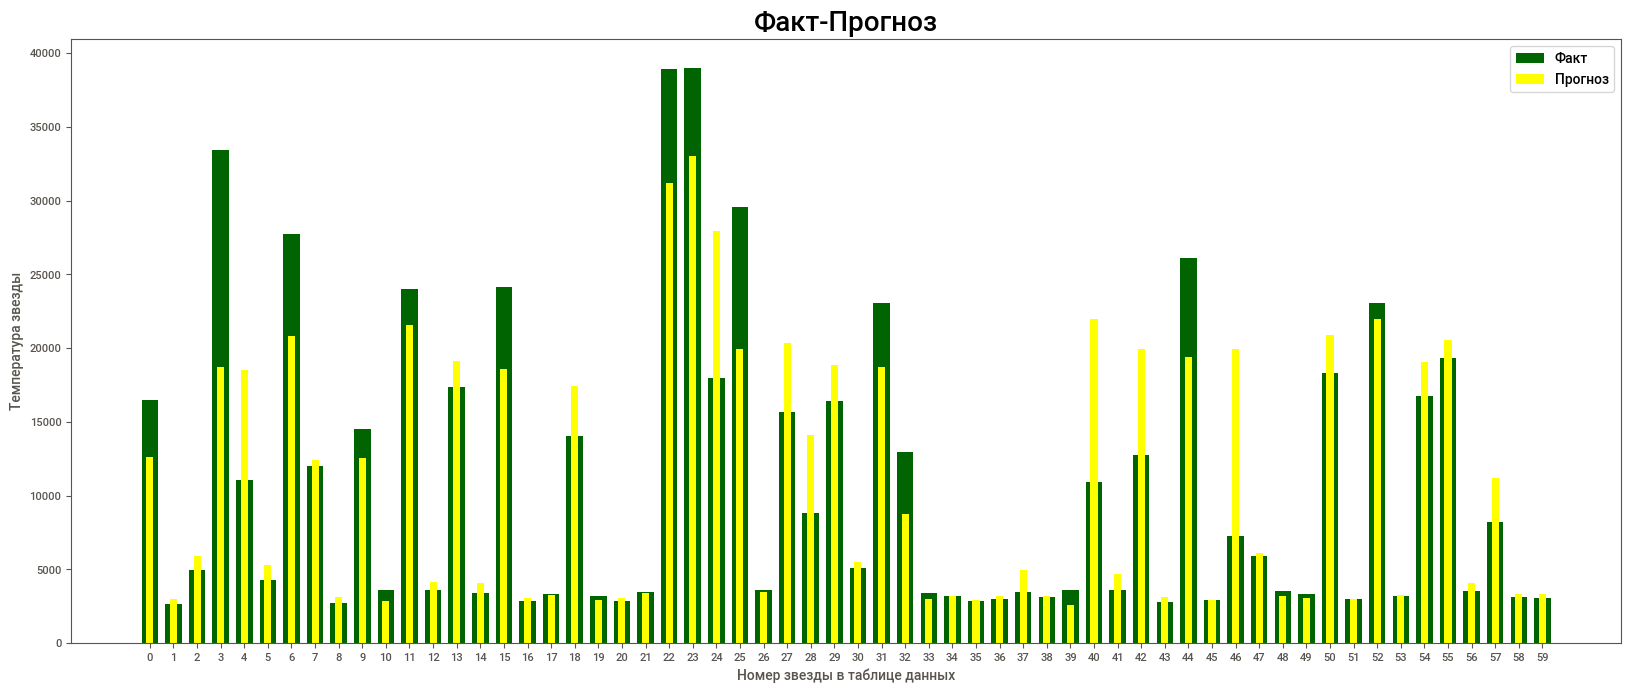

In [23]:
torch.manual_seed(2024)
torch.use_deterministic_algorithms(True)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)
    
num_epochs = 5000
    
for epoch in range(num_epochs):
    net.train()
    for batch in train_dataloader:
        data_train, temp_train = batch 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temp_train))
        loss_value.backward()
        optimizer.step()
    
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        predict_T = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temp_test = batch

                test_preds = net.forward(data_test).flatten()
                predict_T.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temp_test))

        predict_T = torch.cat(predict_T).detach().numpy()
        RMSE = root_mean_squared_error(y_test, predict_T)
            
        print(f"Эпоха:{epoch}, RMSE на трейне: {RMSE_loss}")
        print(f"Эпоха:{epoch}, RMSE на тесте: {RMSE}")
        print()
                
fact_pred_chart(predict_T, y_test)

In [24]:
print('RMSE улучшенной модели на тестовой выборке', RMSE)

RMSE улучшенной модели на тестовой выборке 4434.8603515625


**Промежуточные выводы:**
- для первой попытки получили соответстующйи целевому значению меньше 4500K,
- сеть работает стабильно, переобучения-недобучения не обнаружено.
Попробуем уменьшить метрику путем подбора батчей/дропаутов

## Улучшение нейронной сети

Попробуем улучшить результаты при помощи подбора гиперпараметров с использованием библиотеки Optuna. В соответствии с заданием не будем менять общую архитектуру сети, оставим количество слоев, нейронов и функции активации. Попробуем перебрать дропауты, шаги при оптимизации и батчи.

In [25]:
# функция для подбора дропаутов
def define_model(trial):
    layers = []

    layers.append(nn.Linear(n_in_neurons, n_hidden_neurons_1))
    layers.append(nn.ReLU())
    p = trial.suggest_float("dropout_1", 0.2, 0.8)
    layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2))
    layers.append(nn.ReLU())
    p = trial.suggest_float("dropout_2", 0.2, 0.8)
    layers.append(nn.Dropout(p))
    
    layers.append(nn.Linear(n_hidden_neurons_2, n_out_neurons))

    return nn.Sequential(*layers)

In [26]:
def objective(trial):
    
    torch.manual_seed(2024)
    torch.use_deterministic_algorithms(True)
    # подбираем гиперпараметры
    batch_size = trial.suggest_int("batch_size", 15, 75, step=10)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    
    # загружаем данные
    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

    net = define_model(trial).to(torch.device("cpu"))
    optimizer = optim.NAdam(net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    num_epochs = 5000
    
    for epoch in range(num_epochs):
        net.train()
        for batch in train_dataloader:
            data_train, temp_train = batch 
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.sqrt(loss(preds, temp_train))
            loss_value.backward()
            optimizer.step()
    
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            predict_T = [] 
            with torch.no_grad():
                net.eval()
                for batch in test_dataloader:
                    data_test, temp_test = batch

                    test_preds = net.forward(data_test).flatten()
                    predict_T.append(test_preds)
                    RMSE_loss = torch.sqrt(loss(test_preds, temp_test))

            predict_T = torch.cat(predict_T).detach().numpy()
            RMSE = root_mean_squared_error(y_test, predict_T)
    return RMSE

In [27]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Статистика обучения: ")
print("  Всего попыток: ", len(study.trials))
print("  Прерванные попытки: ", len(pruned_trials))
print("  Законченные попытки: ", len(complete_trials))

print("Лучшая попытка:")
trial = study.best_trial

print("  Значение RMSE: ", trial.value)

print("  Лучшие параметры: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-12-21 08:47:24,457] A new study created in memory with name: no-name-a4e2fb49-331a-4b23-9240-d791a6b3b6f5
[I 2024-12-21 08:47:42,998] Trial 0 finished with value: 5222.47900390625 and parameters: {'batch_size': 45, 'lr': 0.01774129952265381, 'dropout_1': 0.6852606507276271, 'dropout_2': 0.36460103536499433}. Best is trial 0 with value: 5222.47900390625.
[I 2024-12-21 08:48:54,949] Trial 1 finished with value: 4746.45849609375 and parameters: {'batch_size': 65, 'lr': 0.0011495436637911456, 'dropout_1': 0.23193941274286003, 'dropout_2': 0.25836811750009003}. Best is trial 1 with value: 4746.45849609375.
[I 2024-12-21 08:49:20,758] Trial 2 finished with value: 5507.55224609375 and parameters: {'batch_size': 35, 'lr': 0.025236277216886833, 'dropout_1': 0.515667323177089, 'dropout_2': 0.6521771500329714}. Best is trial 1 with value: 4746.45849609375.
[I 2024-12-21 08:50:34,654] Trial 3 finished with value: 6187.64208984375 and parameters: {'batch_size': 65, 'lr': 0.02920036816199344

Статистика обучения: 
  Всего попыток:  10
  Прерванные попытки:  0
  Законченные попытки:  10
Лучшая попытка:
  Значение RMSE:  4746.45849609375
  Лучшие параметры: 
    batch_size: 65
    lr: 0.0011495436637911456
    dropout_1: 0.23193941274286003
    dropout_2: 0.25836811750009003


 К сожалению существенно улучшить результат не удалось. Перепроверим на тестовой выборке лусчшие парамерты подобранные при помощи Optuna.

In [28]:
b_s_new, lr_new, dp_1, dp_2 = trial.params.values()
print(b_s_new, lr_new, dp_1, dp_2)

65 0.0011495436637911456 0.23193941274286003 0.25836811750009003


Эпоха:0, RMSE на трейне: 14626.6171875
Эпоха:0, RMSE на тесте: 14626.6171875

Эпоха:100, RMSE на трейне: 14533.630859375
Эпоха:100, RMSE на тесте: 14533.630859375

Эпоха:200, RMSE на трейне: 13856.9365234375
Эпоха:200, RMSE на тесте: 13856.935546875

Эпоха:300, RMSE на трейне: 12215.734375
Эпоха:300, RMSE на тесте: 12215.7353515625

Эпоха:400, RMSE на трейне: 10114.708984375
Эпоха:400, RMSE на тесте: 10114.708984375

Эпоха:500, RMSE на трейне: 8650.919921875
Эпоха:500, RMSE на тесте: 8650.9189453125

Эпоха:600, RMSE на трейне: 8053.34423828125
Эпоха:600, RMSE на тесте: 8053.34375

Эпоха:700, RMSE на трейне: 7758.5966796875
Эпоха:700, RMSE на тесте: 7758.5966796875

Эпоха:800, RMSE на трейне: 7574.37744140625
Эпоха:800, RMSE на тесте: 7574.37744140625

Эпоха:900, RMSE на трейне: 7423.05322265625
Эпоха:900, RMSE на тесте: 7423.0537109375

Эпоха:1000, RMSE на трейне: 7304.63671875
Эпоха:1000, RMSE на тесте: 7304.63671875

Эпоха:1100, RMSE на трейне: 7191.9033203125
Эпоха:1100, RMSE на тес

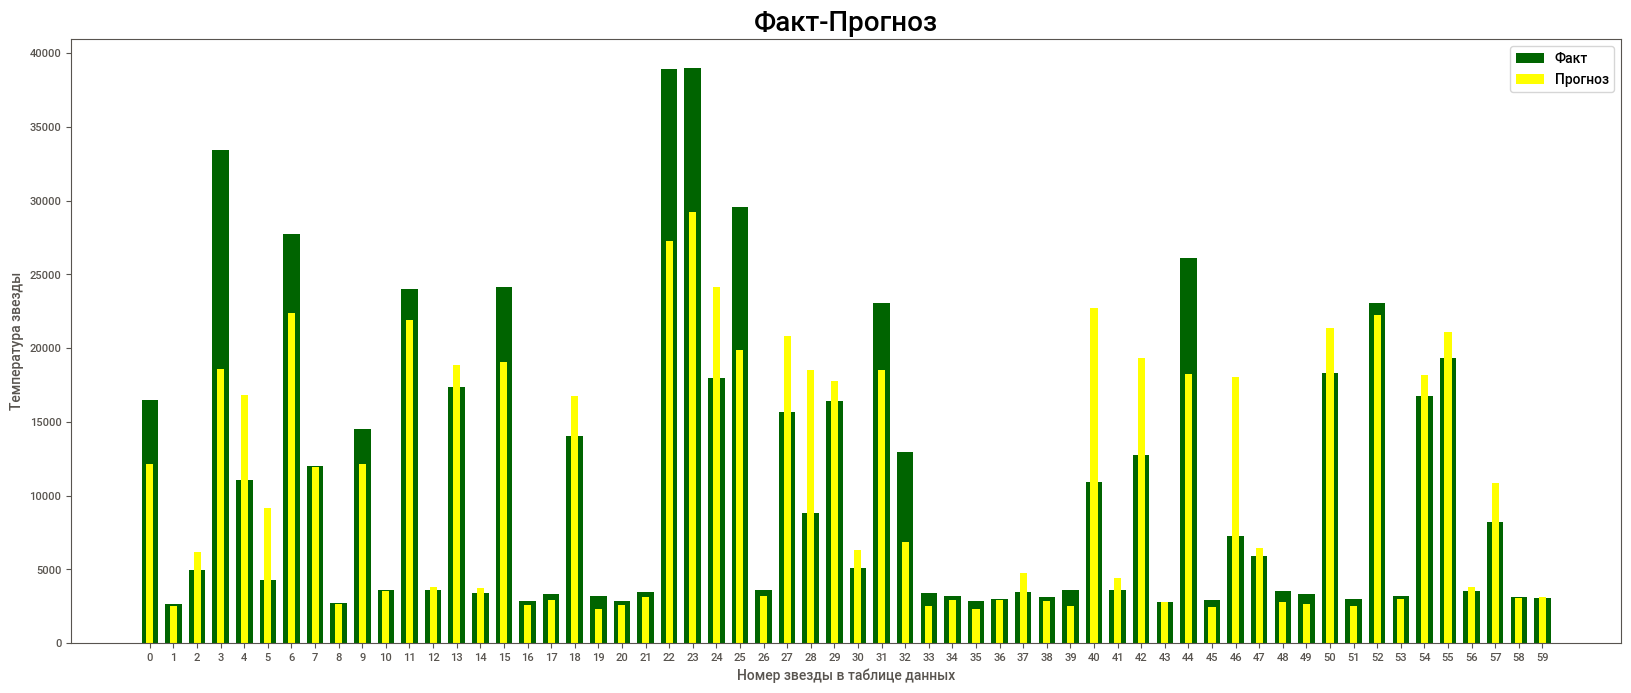

In [29]:
new_net = nn.Sequential(nn.Linear(n_in_neurons, n_hidden_neurons_1),
                        nn.ReLU(),
                        nn.Dropout(dp_1),
                        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
                        nn.ReLU(),
                        nn.Dropout(dp_2),   
                        nn.Linear(n_hidden_neurons_2, n_out_neurons))

new_optimizer = optim.NAdam(new_net.parameters(), lr=lr_new)
new_loss = nn.MSELoss()

new_dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
new_dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

new_train_dataloader = DataLoader(new_dataset_train, batch_size=b_s_new, shuffle=True, num_workers=0)
new_test_dataloader = DataLoader(new_dataset_test, batch_size=b_s_new, num_workers=0)
    
num_epochs = 5000
    
for epoch in range(num_epochs):
    new_net.train()
    for batch in new_train_dataloader:
        data_train, temp_train = batch 
        new_optimizer.zero_grad()

        preds =new_net.forward(data_train).flatten()

        loss_value = torch.sqrt(new_loss(preds, temp_train))
        loss_value.backward()
        new_optimizer.step()
    
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        predict_T = [] 
        with torch.no_grad():
            new_net.eval()
            for batch in new_test_dataloader:
                data_test, temp_test = batch

                test_preds = new_net.forward(data_test).flatten()
                predict_T.append(test_preds)
                RMSE_loss = torch.sqrt(new_loss(test_preds, temp_test))

        predict_T = torch.cat(predict_T).detach().numpy()
        RMSE = root_mean_squared_error(y_test, predict_T)
            
        print(f"Эпоха:{epoch}, RMSE на трейне: {RMSE_loss}")
        print(f"Эпоха:{epoch}, RMSE на тесте: {RMSE}")
        print()
        
fact_pred_chart(predict_T, y_test)

In [30]:
print('RMSE улучшенной модели на тестовой выборке', RMSE)

RMSE улучшенной модели на тестовой выборке 4663.99658203125


Результат стал хуже, чем первая попытка.
Как видим из графика плохие прогнозы показывают те же наблюдения что и в базовой модели. Скорее всего это связано с малым количеством наблюдений, так как в целом для постоения нейросетки у нас достаточно небольшой датасет, в котором есть достаточное количество выбиващихся из общей массы наблюдений, которые мы не стали исключать.

## Выводы

 - загружены имеющиеся данные файла;
 - проведен анализ данных при помощи библиотеки sweetvis:
    - явные дубликаты не обнаружены;
    - рассмотрели распределение количественных и качественых признаков в каждом датафрейме;
    - мульколлинеарность между некоторыми из признаков присутствует, но было принято решение ее не устранять;
    - устранены неявные дубликаты в столбце Star type;
 - пропусков в данных не обнаружено, типизация данных во всех датафреймах корректна;
 - преобразовали признаки для построения нейросети:
 - построили базовую нейросеть с 2мя скрытыми слоями(количество нейронов в скрытых слоях 15 и 12), с оптимизатором NAdam, размером батча 40, функции активации ReLu;
 - базовая модель показала хороший результат на тесте - RMSE меньше 4500K;
 - провели улучшение базовой модели путенм подбора гиперпараметром при помощи библиотеки Optuna;
 - существенного улучшения метрик при использовании дропаутов или иного размра батчей не удалось достичь.
 
 Цель проекта достигнута и базовая модель соответствующая целевой метрике RMSE менее 4500K построена.